In [1]:
import torch
from torch import nn
from torch.nn import functional
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import utils
from model import unet,unet_backbone

In [2]:
torch.manual_seed(17)

In [3]:
voc_dir = '../autodl-tmp/data/VOCdevkit/VOC2012'
# train_features, train_labels = read_voc_images(voc_dir)

In [4]:
crop_size = (320, 480)
voc_train = utils.VOCSegDataset(True, crop_size, voc_dir)
voc_test = utils.VOCSegDataset(False, crop_size, voc_dir)

read 1114 examples
read 1078 examples


In [5]:
batch_size = 32
train_iter = DataLoader(voc_train, batch_size, shuffle=True)
test_iter = DataLoader(voc_test,batch_size,shuffle=False)
# for X, Y in train_iter:
#     print(X.shape[0])

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [7]:
model = unet_backbone.Unet(backbone_name='resnet50').to(device)

upsample_blocks[0] in: 2048   out: 256
upsample_blocks[1] in: 256   out: 128
upsample_blocks[2] in: 128   out: 64
upsample_blocks[3] in: 64   out: 32
upsample_blocks[4] in: 32   out: 16


In [8]:
a = torch.randn(1,3,320,480).to(device)
output = model(a)
print(output.shape)

torch.Size([1, 21, 320, 480])


In [9]:
backbone_params = []
other_params = []
for name,param in model.named_parameters():
    if name.startswith('backbone'):
        backbone_params.append(param)
    else :
        other_params.append(param)
# for name,child in model.named_children():
#     print(name)

In [10]:
lr = 1e-4
# loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
# optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.Adam([{'params': backbone_params,'lr':1e-5},
                              {'params': other_params}],lr=lr)

In [11]:
epochs = 40
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    utils.train(train_iter, device, model, loss_fn, optimizer)
    utils.test(test_iter,device,model,loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.815977  [    0/ 1114]
loss: 2.556706  [  960/ 1114]
Test Error: 
 Accuracy: 64.04%, Avg loss: 2.582966 

Epoch 2
-------------------------------
loss: 2.498562  [    0/ 1114]
loss: 2.449438  [  960/ 1114]
Test Error: 
 Accuracy: 60.68%, Avg loss: 2.416997 

Epoch 3
-------------------------------
loss: 2.326988  [    0/ 1114]
loss: 2.339241  [  960/ 1114]
Test Error: 
 Accuracy: 70.52%, Avg loss: 2.199540 

Epoch 4
-------------------------------
loss: 2.304222  [    0/ 1114]
loss: 2.188656  [  960/ 1114]
Test Error: 
 Accuracy: 69.91%, Avg loss: 2.169536 

Epoch 5
-------------------------------
loss: 2.217086  [    0/ 1114]
loss: 2.155864  [  960/ 1114]
Test Error: 
 Accuracy: 68.73%, Avg loss: 2.153035 

Epoch 6
-------------------------------
loss: 2.104969  [    0/ 1114]
loss: 2.097496  [  960/ 1114]
Test Error: 
 Accuracy: 73.44%, Avg loss: 2.045715 

Epoch 7
-------------------------------
loss: 2.014632  [    0/ 1114]
loss: 2.0210

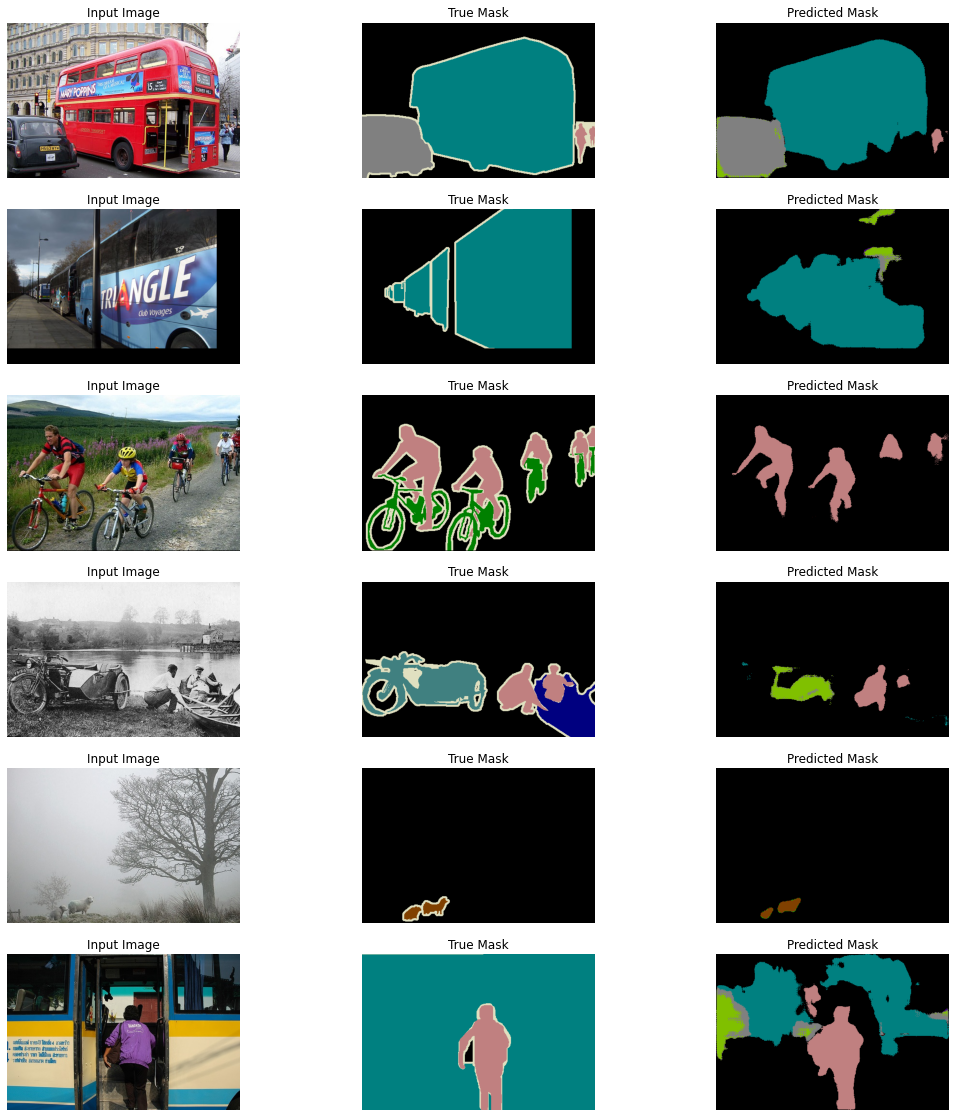

In [15]:
# 裁剪一些图片的一部分进行预测
test_images, test_labels = utils.read_voc_images(voc_dir, False)
n = 6
rows,cols = n,3
title = ['Input Image', 'True Mask', 'Predicted Mask']
plt.figure(figsize=(18, 20))
for i in range(n):
    idx = torch.randint(len(test_images),(1,)).item()
    crop_rect = (0, 0, 320, 480)
    X = torchvision.transforms.functional.crop(test_images[idx], *crop_rect)
    pred = utils.label2image(utils.predict(X,test_iter,device,model),device)
    img_list = [X.permute(1,2,0),
                torchvision.transforms.functional.crop(test_labels[idx],*crop_rect).permute(1,2,0),
                pred.cpu()]
    for j,img in enumerate(img_list):
        plt.subplot(rows,cols,i*cols+j+1)
        plt.title(title[j])
        # plt.imshow(transforms.ToPILImage()(img))
        plt.imshow(img.numpy())
        plt.axis('off')
plt.show()

In [16]:
torch.save(model,'UNet-backbone-resnet50-40epochs.pt')